In [3]:
import os
import csv
import logging 

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.spatial as ss
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D
from stellargraph import StellarDiGraph, StellarGraph
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [2]:
import imp
from cell import plot_utils, graph_utils,analysis, utils
import cell.BiasedDirectedWeightedWalk as BDWW

imp.reload(plot_utils)
imp.reload(graph_utils)
imp.reload(plot_utils)
imp.reload(BDWW)

<module 'cell.BiasedDirectedWeightedWalk' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/BiasedDirectedWeightedWalk.py'>

### Read NPP interactions

In [53]:
cldf = utils.read_visp_npp_cldf("old")
layers = utils.get_npp_visp_layers(version="0.0")
int_mat = utils.read_npp_interaction_df(version="0.0", 
                                        which_layers=layers, 
                                        index=cldf.cluster_label, 
                                        columns=cldf.cluster_label)

Reading cldf from: //Users/fahimehb/Documents/NPP_GNN_project/dat/cl_df_VISp_annotation.csv


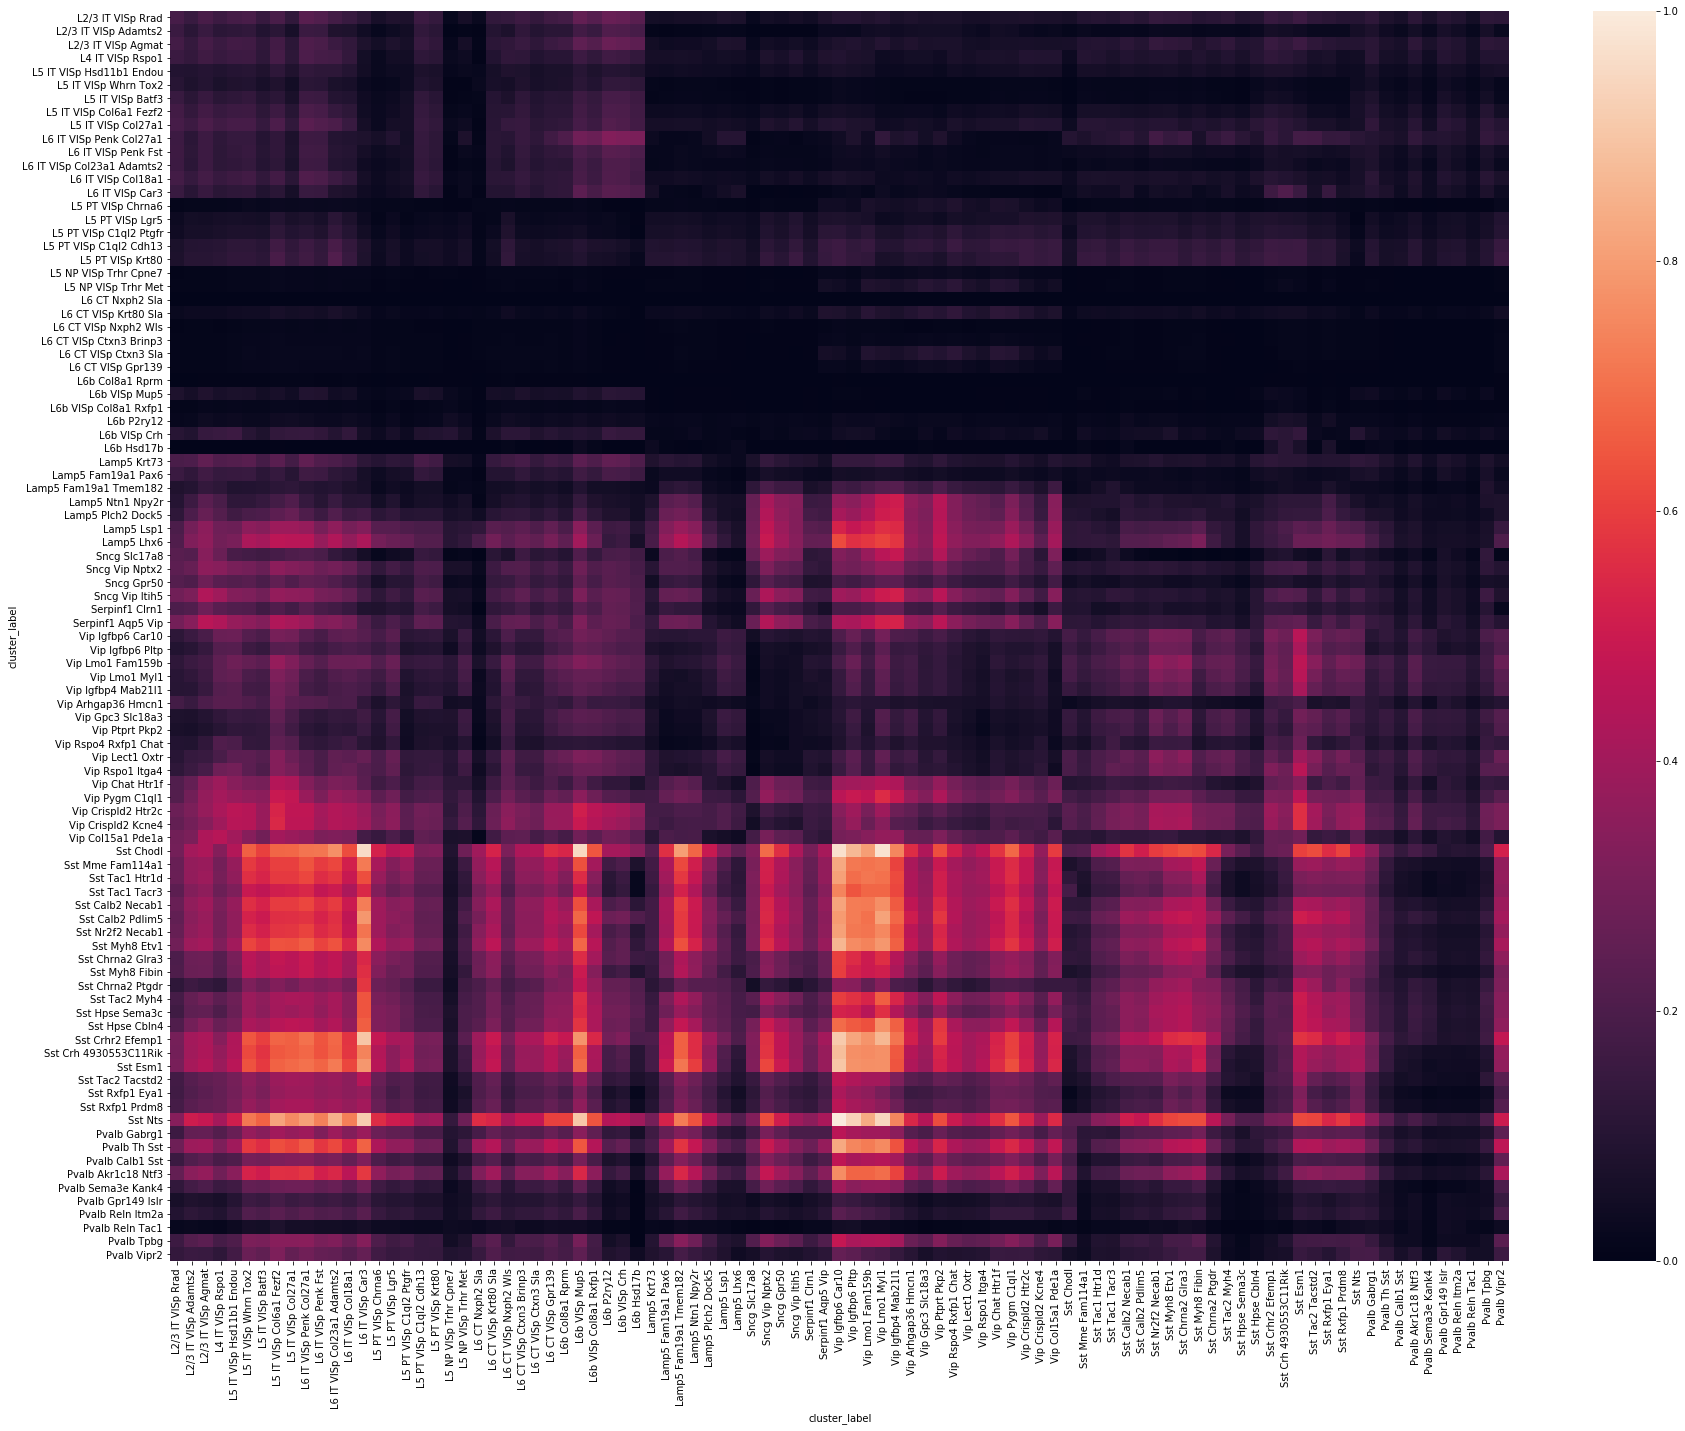

In [54]:
fig = plt.figure(figsize=(30,23))
sns.heatmap(int_mat/np.max(np.max(int_mat)))
fig.savefig("/Users/fahimehb/Documents/NPP_GNN_project/dat/fig/Intmat-all.pdf")

### Visualize all weight matrices

In [42]:
data = pd.DataFrame()

for k, v in Interactions_VISp.items():
    v = v.stack().reset_index()
    v["channel_id"] = k.split("_")[0]
    v.columns = ["type1", "type2", "value", "channel_id"]
    data = data.append(pd.DataFrame(v), ignore_index=True)

In [43]:
data

,type1,type2,value,channel_id
0,0,0,0.000000,Pdyn-Oprk1
1,0,1,0.000000,Pdyn-Oprk1
2,0,2,0.000184,Pdyn-Oprk1
3,0,3,0.000000,Pdyn-Oprk1
4,0,4,0.000000,Pdyn-Oprk1
...,...,...,...,...
320008,92,88,0.009295,Cort-Sstr1
320009,92,89,0.000000,Cort-Sstr1
320010,92,90,0.000000,Cort-Sstr1
320011,92,91,0.003328,Cort-Sstr1


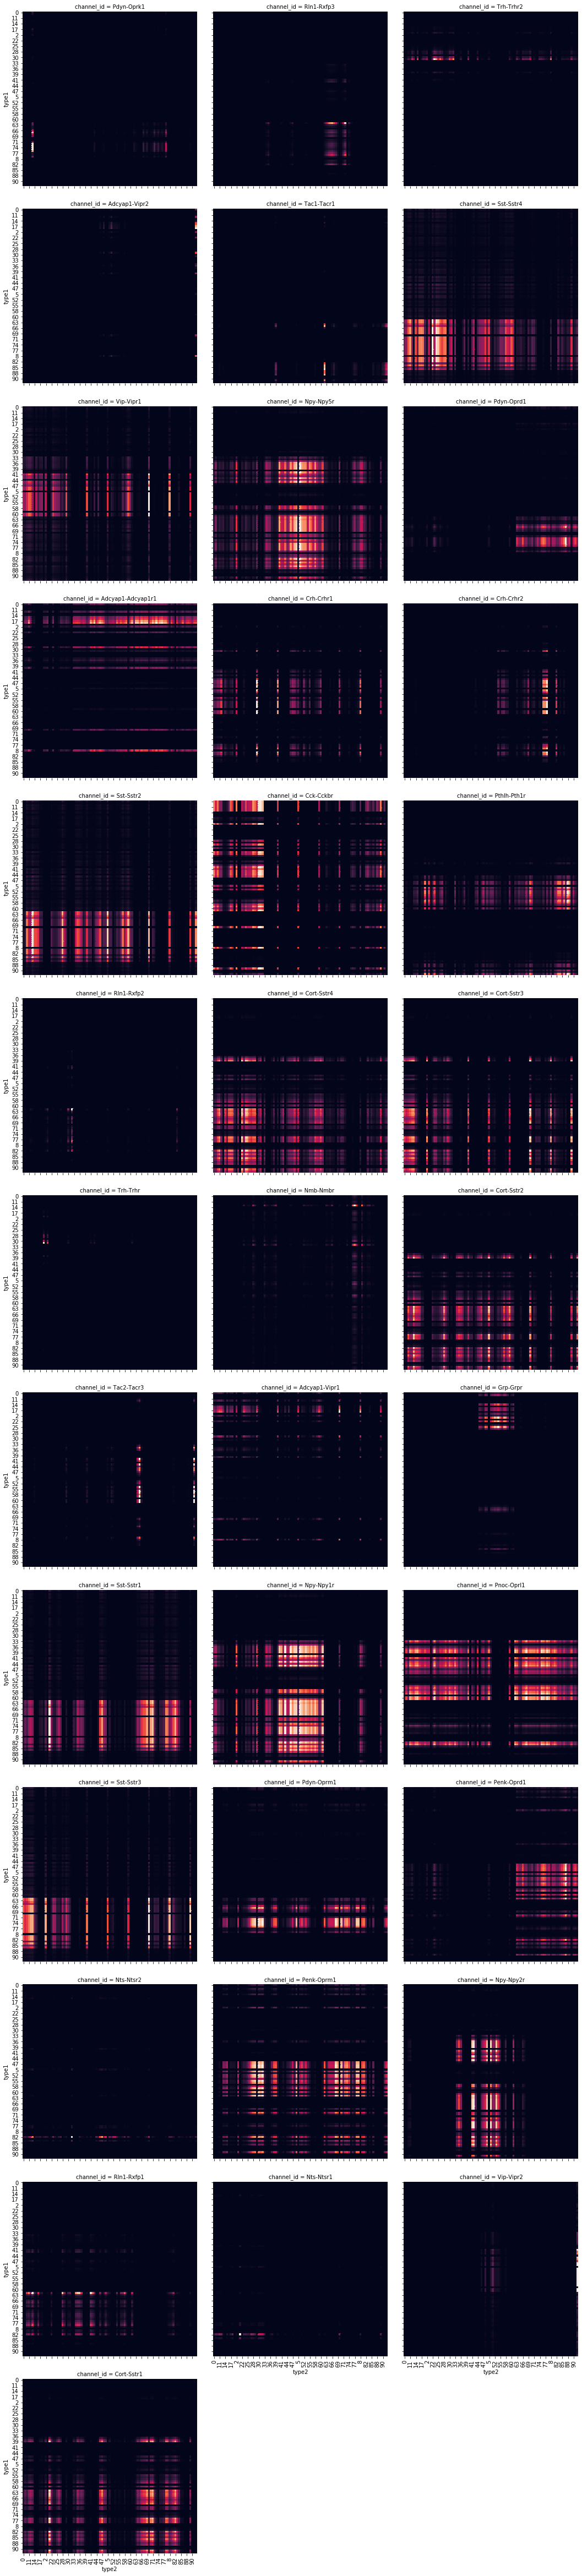

In [25]:
plot_utils.Facet_Grid_Heatmap(data, "channel_id", 3, 5, "type2", "type1", "value")

# What if i pick the 7 connection only for each graph

In [44]:
data = pd.DataFrame()

for k, v in Interactions_VISp.items():
    df = graph_utils.Keep_only_k_largest_value_of_each_row_and_each_column(v, k=7)
    df = df.stack().reset_index()
    df["channel_id"] = k.split("_")[0]
    df.columns = ["type1", "type2", "value", "channel_id"]
    data = data.append(pd.DataFrame(df), ignore_index=True)

In [45]:
data.head()

,type1,type2,value,channel_id
0,0,0,0.0,Pdyn-Oprk1
1,0,1,0.0,Pdyn-Oprk1
2,0,2,0.0,Pdyn-Oprk1
3,0,3,0.0,Pdyn-Oprk1
4,0,4,0.0,Pdyn-Oprk1


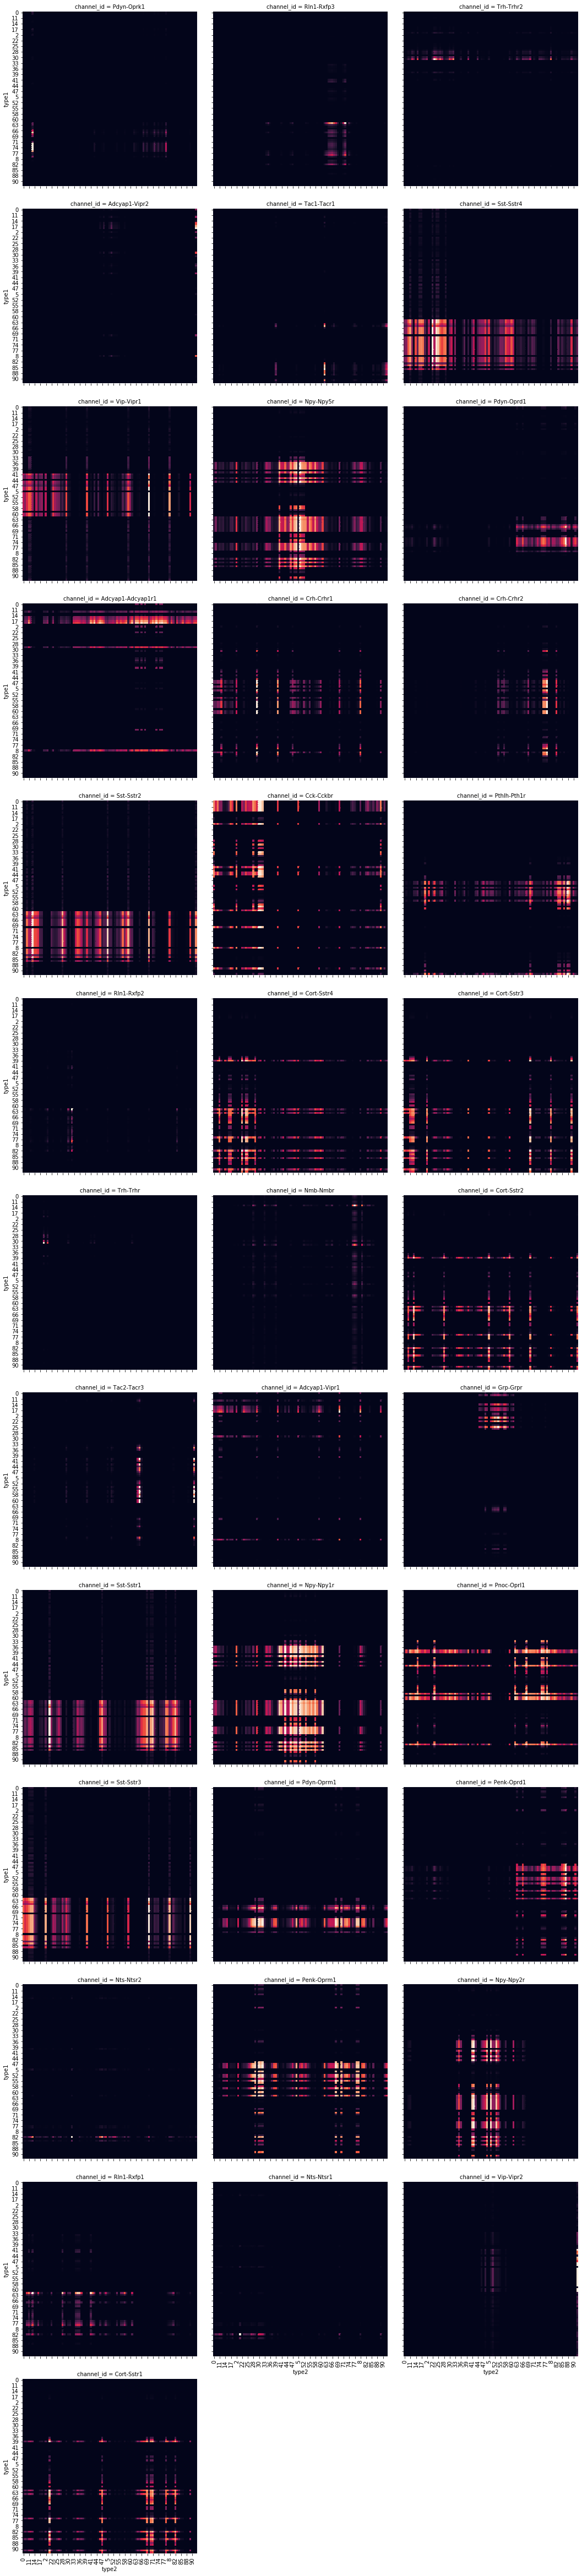

In [46]:
plot_utils.Facet_Grid_Heatmap(data, "channel_id", 3, 5, "type2", "type1", "value")

### Generate graphs for each individual weight matrix

The graphs must be made as directed graphs. Meaning that if node1 and node2 have an edge, we might be able to go from 1 to 2 but we might not be able to go back. For this, in the matrices that we have the direction is from NPP gene >>>>> NP-GPCR gene. For example from Sst >>>> Sstr2, or from Npy >>>> Npyr1. In the matrices therefore, y axis showes the "source node" and x axis shows the "target node". 

In [16]:
matrix_dir = "/home/pogo/work_dir/NPP-GNN-project/dat/Interaction_mats/"
graph_dir = "/home/pogo/work_dir/NPP-GNN-project/dat/graphs/"
region = "VISp"

for channel in NPP_channels_df['channel']:
    matrix_file_name = os.path.join(matrix_dir, region, channel+".csv")
    w_mat = pd.read_csv(matrix_file_name, index_col="Unnamed: 0")
    source_target_weight = graph_utils.Build_edge_list(weight_matrix=w_mat, threshold=0, directed=True)
    
    edge_dir = os.path.join(graph_dir, region, channel)
    
    if not os.path.isdir(edge_dir):
        os.mkdir(edge_dir)
    #os.remove(edge_dir+ "/nodes.csv")
    source_target_weight.to_csv(edge_dir + "/edges.csv")
    

Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph edge list
Bsource_target_weightuidling a directed graph ed

### Add a self connection to the edgelists and save them to another file

In [28]:
parrent_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/graphs/VISp/"
layers = os.listdir(parrent_dir)

In [73]:
for layer in layers:
    file_name = os.path.join(parrent_dir, layer, "edges.csv")
    tmp_edge = pd.read_csv(file_name, index_col="Unnamed: 0")
    
    #0) for each graph we will add a self connection per node if it is not already there
    tmp_edge = graph_utils.fix_self_connection(tmp_edge, weighted=True)
    new_file_name = os.path.join(parrent_dir, layer, "modifed_edges.csv")
    tmp_edge.to_csv(new_file_name)

### Preparing to walk on a multigraph

In [83]:
nx_graphs = {} #keep all the nxDigraphs
stellar_Di_graphs = {} #keep all the stellarDigraphs
node_importance = {} #keep all the node_importance per layers
layer_importance = {}

for layer in layers:
    file_name = os.path.join(parrent_dir, layer, "edges.csv")
    tmp_edge = pd.read_csv(file_name, index_col="Unnamed: 0")
    tmp_edge[['source', 'target']] = tmp_edge[['source', 'target']].astype(str)
    
    #1) for each layer first create a nx-Digraph
    nxg = graph_utils.Build_nx_Graph(source_target_weight=tmp_edge, directed=True) 
    nx_graphs[layer] = nxg
    
    #2) Create stellar Di graphs
    sdg = StellarDiGraph(nxg)
    stellar_Di_graphs[layer] = sdg
    
    #3) Initialize the walk and return the layer_node_importance
    obj = BDWW.BeginWalk(sdg, begin_checks=True,weighted=True, directed=True)
    node_importance[layer] = obj.node_importance
    print("for layer: ", layer, "this is the end node:" , obj.end_nodes)
    
#4) Find all the nodes in all the graphs    
base_nodes = BDWW.get_all_nodes(stellar_Di_graphs)

#5) Find the node importance
layer_importance = BDWW.get_layer_importance(base_nodes, node_importance)

### Walk on a multigraph
This is just a demo, we need to run this on multiple cpu to be able to get a good amount of walks

In [75]:
walks = BDWW.biased_directed_multi_walk(stellar_multi_graph_dict=stellar_Di_graphs, 
                                nodes=base_nodes, 
                                layer_importance=layer_importance, 
                                n=3, 
                                length=10, 
                                p=1, 
                                q=1, 
                                tol=10**-6, 
                                weighted=True, 
                                directed=True)[0]

# Word2vec

In [254]:
single_walk_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/single_layer/Directed_Weighted_node2vec/N_1000_l_10_p_1_q_1/"
dat_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/"
fig_dir="/Users/fahimehb/Documents/NPP_GNN_project/dat/output-figures/"

layers = os.listdir(single_walk_dir)
job_id = 0

22209.11328125
94876.78125
45263.37890625
115072.203125
115973.859375
141657.765625
120577.140625
178820.8125
236205.796875
207237.21875


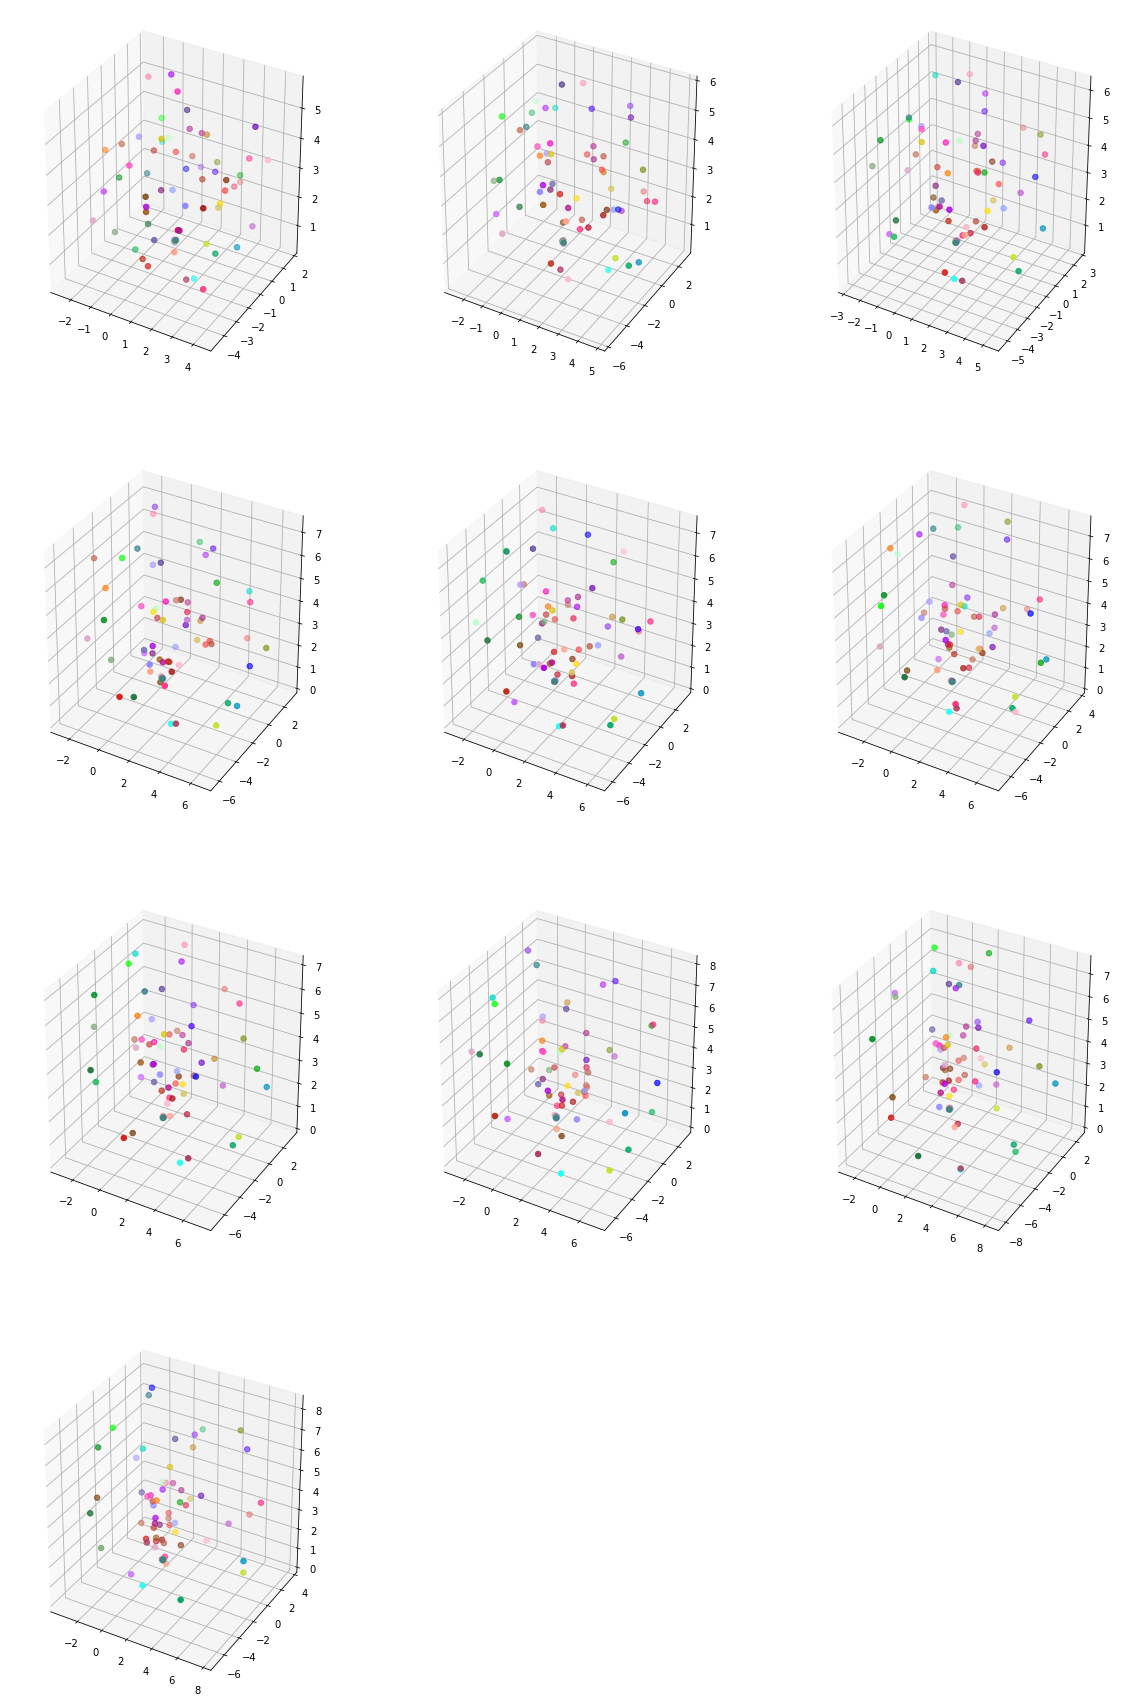

In [266]:
weighted_model = {}

fig = plt.figure(figsize=(20,120))
i=1
for layer in [layers[0]]:
    walk_path = os.path.join(single_walk_dir, layer)
    n_iter = os.listdir(walk_path)
    walks = []
    for n in n_iter:
        walks = walks + utils.Read_List_of_Lists_from_CSV(walk_path, "/walk_"+ str(job_id)+ ".csv")
        
        weighted_model[layer] = Word2Vec(walks, 
                          size= 3, 
                          window= 3, 
                          min_count= 1, 
                          sg= 1, 
                          workers= 5, 
                          iter= 1,
                          seed=1,
                          compute_loss=True)
        
        print(weighted_model[layer].get_latest_training_loss())
    
        cl_df = pd.read_csv(dat_dir + "cl_df_150cl.csv", index_col = "Unnamed: 0")
        data = analysis.summarize_walk_embedding_results(gensim_dict=weighted_model, ndim=3, cl_df=cl_df)

        ax = fig.add_subplot(15, 3, i, projection='3d')
        ax.scatter(data['Z0'], data['Z1'], data['Z2'], color= data['cluster_color'], s=30)
        i = i + 1

    plt.show()

# Vip-Vipr2

98848.578125
175735.109375
260313.703125
343844.09375
444548.28125
530708.8125
610689.375
693924.5
771866.9375
848625.0625


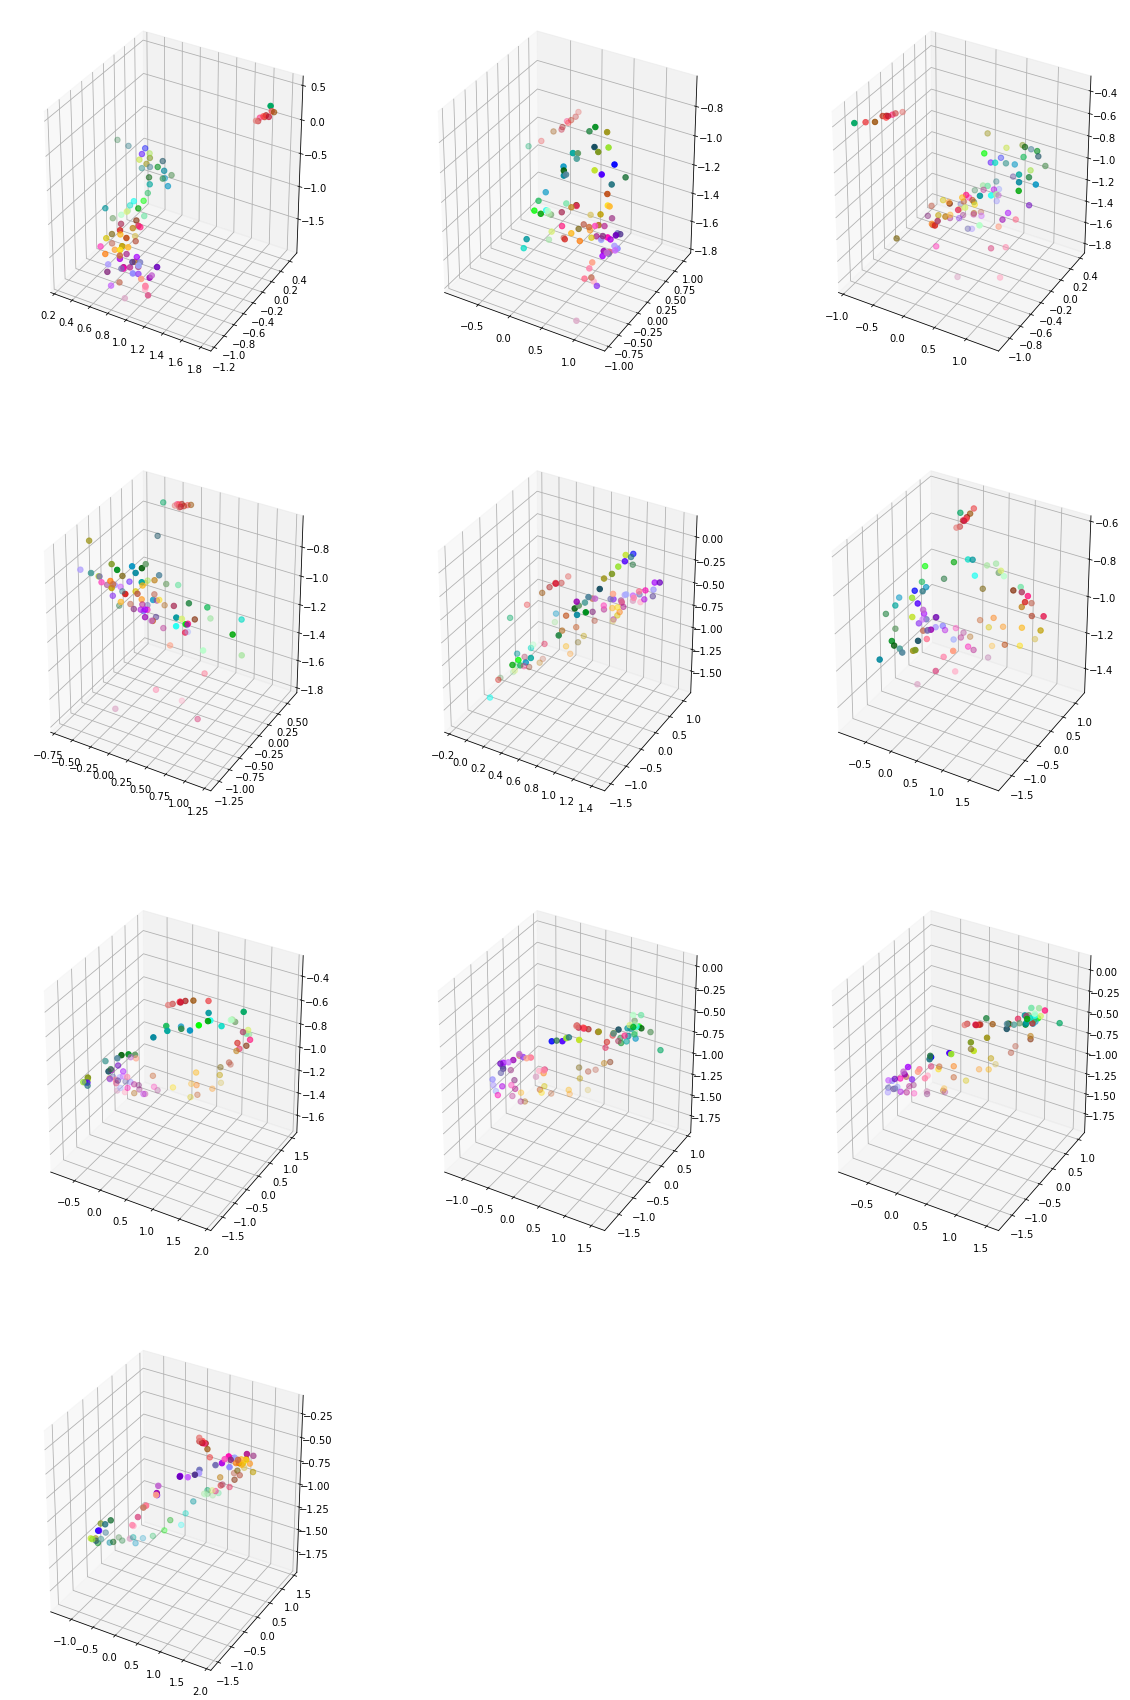

In [285]:
weighted_model = {}

fig = plt.figure(figsize=(20,120))
i=1
for layer in [layers[31]]:
    walk_path = os.path.join(single_walk_dir, layer)
    n_iter = os.listdir(walk_path)
    walks = []
    for n in n_iter:
        walks = walks + utils.Read_List_of_Lists_from_CSV(walk_path, "/walk_"+ str(job_id)+ ".csv")
        
        weighted_model[layer] = Word2Vec(walks, 
                          size= 3, 
                          window= 3, 
                          min_count= 1, 
                          sg= 1, 
                          workers= 5, 
                          iter= 1,
                          seed=1,
                          compute_loss=True)
        
        print(weighted_model[layer].get_latest_training_loss())
    
        cl_df = pd.read_csv(dat_dir + "cl_df_150cl.csv", index_col = "Unnamed: 0")
        data = analysis.summarize_walk_embedding_results(gensim_dict=weighted_model, ndim=3, cl_df=cl_df)

        ax = fig.add_subplot(15, 3, i, projection='3d')
        ax.scatter(data['Z0'], data['Z1'], data['Z2'], color= data['cluster_color'], s=30)
        i = i + 1

    plt.show()

# Base embedding (with multi layer walks)

In [269]:
multi_walk_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/walks/VISp/multi_layer/Directed_Weighted_node2vec/N_1000_l_100_p_1_q_1/"
dat_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/"
fig_dir="/Users/fahimehb/Documents/NPP_GNN_project/dat/output-figures/"

33765908.0
36633524.0
40107196.0
43788572.0
47370120.0
51054080.0
54955696.0
58767324.0
62762000.0


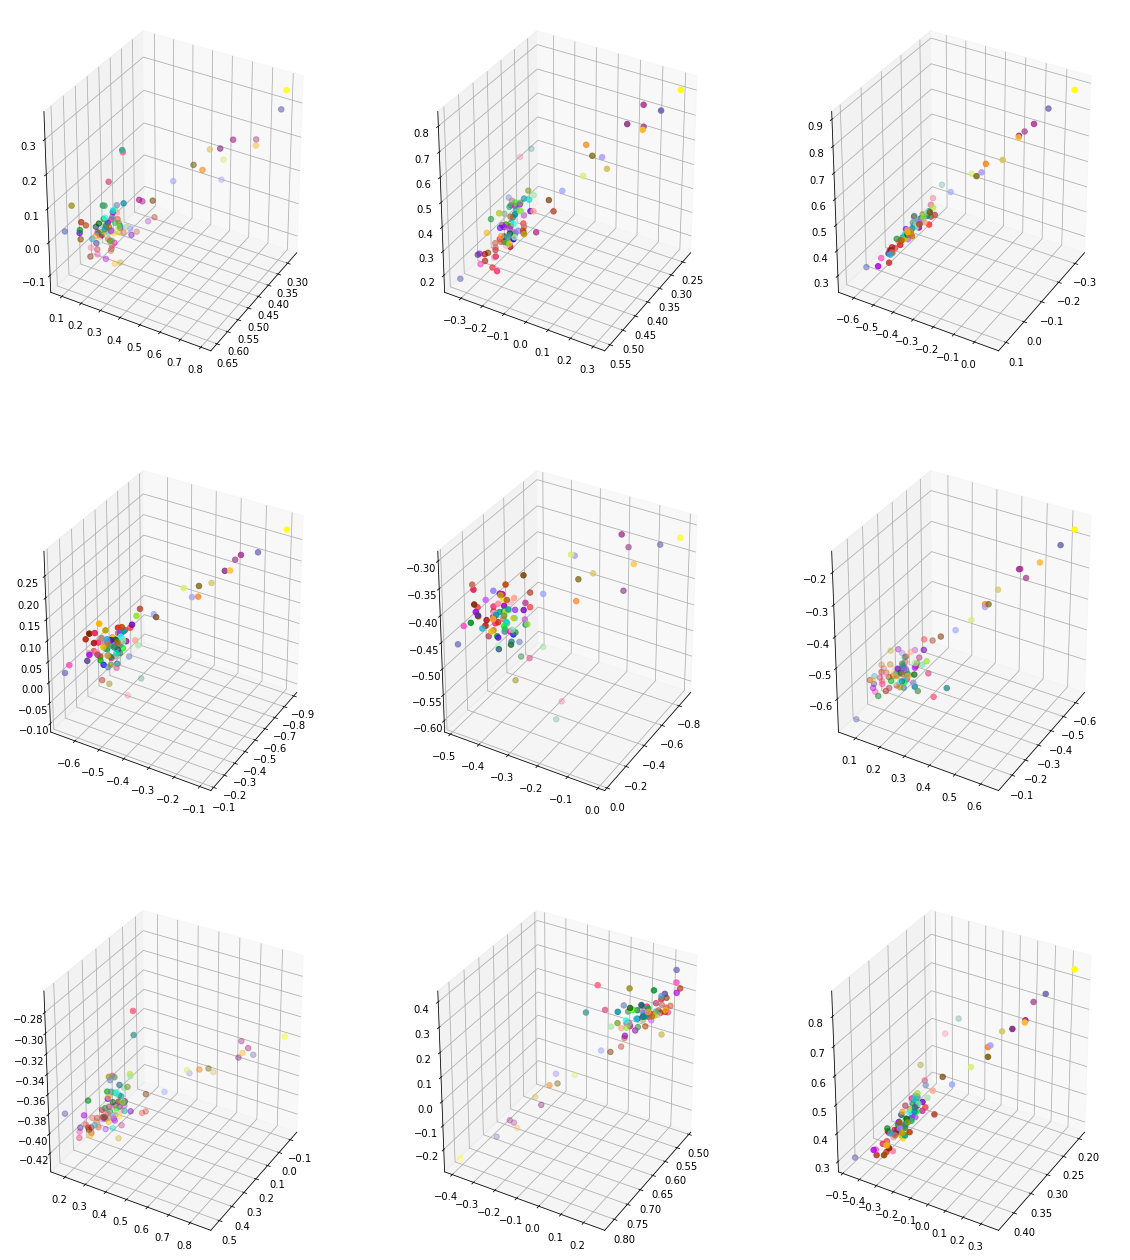

In [284]:
walks = []
fig = plt.figure(figsize=(20,120))
j = 1
for i in range(1,10):
    filename = "walk_"+str(i)+".csv"
    walks = walks + utils.Read_List_of_Lists_from_CSV(multi_walk_dir,filename)
    weighted_model = Word2Vec(walks, 
                          size= 3, 
                          window= 5, 
                          min_count= 0, 
                          sg= 1, 
                          workers= 1, 
                          iter= 1,
                          seed=1, 
                             compute_loss=True)
    print(weighted_model.get_latest_training_loss())
    data = analysis.summarize_walk_embedding_results(gensim_dict={"multi":weighted_model}, ndim=3, cl_df=cl_df)
    
    subdata = data
    subdata = data[data['cluster_label']!="Vip Ptprt Pkp2"]


    ax = fig.add_subplot(15, 3, j, projection='3d')
    ax.scatter(subdata['Z0'], subdata['Z1'], subdata['Z2'], color= subdata['cluster_color'], s=30)
    ax.view_init(30,30)
    j = j + 1

plt.show()

In [292]:
weighted_model[layer] = Word2Vec(walks[0:1000], 
                          size= 3, 
                          window= 3, 
                          min_count= 1, 
                          sg= 1, 
                          workers= 5, 
                          iter= 1,
                          seed=1,
                          compute_loss=True)
        
print(weighted_model[layer].get_latest_training_loss())
    


2772.709228515625


As we dont understand what is going on wit the embeddings. We are going to work only on one graph and put all the edges on one base graph and understand that first. For that I will open another notebook Deepdive


In [ ]:
# groups = data.groupby(by = "channel_id")
# %matplotlib inline
# fig = plt.figure(figsize=(20,120))

# i= 1 
# for g, v in groups:
#     ax = fig.add_subplot(15, 3, i, projection='3d')
#     ax.scatter(v['Z0'], v['Z1'], v['Z2'], color= v['cluster_color'], s=30)
#     ax.set_title(g)
#     i = i + 1
# plt.savefig(fig_dir+"Individual_embeddings.png")
# plt.show()